In [14]:
import torch
import clip
import numpy as np
from PIL import Image, ImageEnhance
import faiss
from tqdm import tqdm
import json
import os
from pathlib import Path
import gc
import time
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

In [16]:
print("SYSTEM CHECK")
print("="*30)

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check CUDA GPU availability
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU Available: {gpu_name} ({gpu_memory:.1f}GB)")
    device = "cuda"
else:
    print("Using CPU (GPU not available)")
    device = "cpu"

# Load CLIP model
try:
    model, preprocess = clip.load("ViT-B/32", device=device)
    print("CLIP loaded successfully")
except Exception as e:
    print(f"CLIP error: {e}")

# Test FAISS library
try:
    test_index = faiss.IndexFlatIP(512)
    print("FAISS is working")
except Exception as e:
    print(f"FAISS error: {e}")

print(f"\nUsing device: {device}")
print(f"Current working directory: {Path.cwd()}")

# Check images folder existence
images_dir = Path(r"C:/Users/vaibhava/usecasedev/image_search_case_study/data/images")

if images_dir.exists():
    print(f"Found images directory: {images_dir}")
else:
    print(f"Images directory not found: {images_dir}")
    os.makedirs(images_dir, exist_ok=True)
    print(f"Created images directory: {images_dir}")

SYSTEM CHECK
PyTorch version: 2.5.1+cu121
GPU Available: NVIDIA RTX A1000 Laptop GPU (4.3GB)
CLIP loaded successfully
FAISS is working

Using device: cuda
Current working directory: c:\Users\vaibhava\usecasedev\image_search_case_study\notebooks
Found images directory: C:\Users\vaibhava\usecasedev\image_search_case_study\data\images


In [17]:
import glob
import os
from pathlib import Path

print("Image Data Directory Check")
print("=" * 50)

# Your exact path
image_directory = Path(r"C:\Users\vaibhava\usecasedev\image_search_case_study\data\images")
print(f"Target directory: {image_directory}")

# Check if directory exists
if image_directory.exists():
    print("Directory found!")

    # Find all image files using glob
    all_jpg_files = list(image_directory.glob("*.jpg"))

    print(f"Total image files found: {len(all_jpg_files)}")

    if len(all_jpg_files) > 0:
        # Sort files numerically if they follow 00001.jpg pattern
        def extract_number(filepath):
            filename = filepath.stem  # filename without extension
            try:
                return int(filename)
            except ValueError:
                return float('inf')

        all_jpg_files.sort(key=extract_number)
        print("Files sorted")

        # Show samples
        print(f"\nFirst 10 files:")
        for i, file_path in enumerate(all_jpg_files[:10]):
            file_size_kb = file_path.stat().st_size / 1024  # size in KB
            print(f"  {i + 1:2d}. {file_path.name} ({file_size_kb:.1f} KB)")

        print(f"\nLast 5 files:")
        for i, file_path in enumerate(all_jpg_files[-5:]):
            print(f"  {len(all_jpg_files) - 4 + i:5d}. {file_path.name}")

        # Store the list for next steps
        image_paths = [str(fp) for fp in all_jpg_files]

        print(f"\nReady to process {len(image_paths)} images")
        print(f"Estimated processing time: {len(image_paths) * 0.05:.1f} minutes")

    else:
        print("No imagefiles found in directory")
        print("Please check if files exist and have .jpg extension")
        image_paths = []

else:
    print(f"Directory not found: {image_directory}")
    print("Please check the path and make sure it exists")
    image_paths = []

print(f"\nResult: {len(image_paths) if 'image_paths' in locals() else 0} images ready for processing")


Image Data Directory Check
Target directory: C:\Users\vaibhava\usecasedev\image_search_case_study\data\images
Directory found!
Total image files found: 24943
Files sorted

First 10 files:
   1. 0001.jpg (72.2 KB)
   2. 0002.jpg (66.7 KB)
   3. 0003.jpg (90.4 KB)
   4. 0004.jpg (36.4 KB)
   5. 0005.jpg (38.3 KB)
   6. 0006.jpg (69.5 KB)
   7. 0007.jpg (36.2 KB)
   8. 0008.jpg (55.7 KB)
   9. 0009.jpg (44.0 KB)
  10. 0010.jpg (61.0 KB)

Last 5 files:
  24939. 24996.jpg
  24940. 24997.jpg
  24941. 24998.jpg
  24942. 24999.jpg
  24943. 25000.jpg

Ready to process 24943 images
Estimated processing time: 1247.2 minutes

Result: 24943 images ready for processing


In [18]:
import glob
import re
from pathlib import Path

def find_all_images(base_dir=r"C:\Users\vaibhava\usecasedev\image_search_case_study\data\images", max_images=25000):
    """
    Robust image discovery that finds ALL images regardless of naming pattern
    """
    print(f"IMAGE DISCOVERY")
    print("="*40)
    
    base_path = Path(base_dir)
    
    if not base_path.exists():
        print(f"Directory {base_dir} does not exist!")
        return []
    
    print(f"Searching in: {base_path.absolute()}")
    
    # Define all possible patterns (case-insensitive)
    patterns = [
        "*.jpg", "*.jpeg", "*.JPG", "*.JPEG", "*.Jpg", "*.Jpeg",
        "*.png", "*.PNG", "*.Png",
        "*.bmp", "*.BMP", "*.Bmp"
    ]
    
    all_image_paths = []
    
    # Search with each pattern
    for pattern in patterns:
        matches = list(base_path.glob(pattern))
        all_image_paths.extend(matches)
        if matches:
            print(f"  Pattern {pattern:<10}: {len(matches)} files")
    
    # Remove duplicates and convert to strings
    unique_paths = list(set([str(p) for p in all_image_paths]))
    
    # Sort by numeric part if possible
    def extract_number(filepath):
        filename = Path(filepath).stem
        numbers = re.findall(r'\d+', filename)
        if numbers:
            return int(numbers[0])
        return float('inf')  # Put non-numeric files at end
    
    try:
        unique_paths.sort(key=extract_number)
    except:
        unique_paths.sort()  # Fallback to alphabetical sort
    
    # Limit to max_images to avoid memory issues with huge datasets
    if len(unique_paths) > max_images:
        unique_paths = unique_paths[:max_images]
        print(f"Limited to first {max_images} images")
    
    print(f"\nDISCOVERY RESULTS:")
    print(f"   Total images found: {len(unique_paths)}")
    
    if unique_paths:
        print(f"   First 5: {[Path(p).name for p in unique_paths[:5]]}")
        print(f"   Last 5: {[Path(p).name for p in unique_paths[-5:]]}")
        
        # Show file size info
        sample_path = Path(unique_paths[0])
        if sample_path.exists():
            file_size = sample_path.stat().st_size / 1024  # KB
            print(f"   Sample file size: {file_size:.1f} KB")
    
    return unique_paths

# Test the discovery function
found_images = find_all_images()

if len(found_images) == 0:
    print("\nNO IMAGES FOUND!")

elif len(found_images) < 1000:
    print(f"\nOnly {len(found_images)} images found")
else:
    print(f"\nFound {len(found_images)} images - ready to proceed")

# Save the image paths for next steps
image_paths = found_images

IMAGE DISCOVERY
Searching in: C:\Users\vaibhava\usecasedev\image_search_case_study\data\images
  Pattern *.jpg     : 24943 files
  Pattern *.JPG     : 24943 files
  Pattern *.Jpg     : 24943 files

DISCOVERY RESULTS:
   Total images found: 24943
   First 5: ['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg']
   Last 5: ['24996.jpg', '24997.jpg', '24998.jpg', '24999.jpg', '25000.jpg']
   Sample file size: 72.2 KB

Found 24943 images - ready to proceed


In [19]:
import os
from typing import List, Tuple
import torch
import clip
from PIL import Image, ImageEnhance
import numpy as np

class OptimizedEmbeddingGenerator:
    """
    Embedding generator
    ViT-B/32 with smart batching and memory management
    """
    
    def __init__(self, device: str = "cuda", model_name: str = "ViT-B/32"):
        self.device = device
        self.model_name = model_name
        
        print(f"Initializing {model_name} on {self.device}")
        if self.device == "cuda":
            try:
                gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
                print(f"   GPU Memory: {gpu_memory:.2f} GB")
            except Exception:
                print("   GPU memory info unavailable")
        
        # Load CLIP model
        self.model, self.preprocess = clip.load(model_name, device=self.device)
        self.model.eval()
        
        # Clear cache if cuda
        if self.device == "cuda":
            torch.cuda.empty_cache()
    
    def enhance_image(self, image: Image.Image) -> Image.Image:
        """Quick image enhancement for better features"""
        try:
            enhancer = ImageEnhance.Contrast(image)
            image = enhancer.enhance(1.15)
            
            enhancer = ImageEnhance.Sharpness(image)
            image = enhancer.enhance(1.1)
            
            return image
        except Exception as e:
            print(f"Warning: Image enhancement failed: {e}")
            return image
    
    def process_batch(self, image_paths_batch: List[str]) -> Tuple[np.ndarray, List[str]]:
        """Process a batch of images efficiently and return embeddings"""
        batch_images = []
        valid_paths = []
        
        for img_path in image_paths_batch:
            try:
                if not os.path.exists(img_path):
                    continue
                
                image = Image.open(img_path).convert("RGB")
                
                # Skip very low resolution images
                if image.size[0] < 64 or image.size[1] < 64:
                    continue
                
                image = self.enhance_image(image)
                processed = self.preprocess(image)
                batch_images.append(processed)
                valid_paths.append(img_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
        
        if not batch_images:
            return None, []
        
        try:
            batch_tensor = torch.stack(batch_images).to(self.device)
            with torch.no_grad():
                embeddings = self.model.encode_image(batch_tensor)
                embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)
            
            embeddings_np = embeddings.cpu().numpy()
            
            del batch_tensor, embeddings
            if self.device == "cuda":
                torch.cuda.empty_cache()
            
            return embeddings_np, valid_paths
        
        except Exception as e:
            print(f"Error generating embeddings: {e}")
            return None, []

print("INITIALIZING EMBEDDING GENERATOR")
print("="*40)

# Use this after device is set in previous cell
generator = OptimizedEmbeddingGenerator(device=device)
print("Embedding generator ready")


INITIALIZING EMBEDDING GENERATOR
Initializing ViT-B/32 on cuda
   GPU Memory: 4.29 GB
Embedding generator ready


In [20]:
import time
import os
import numpy as np
from tqdm import tqdm

def generate_embeddings_batch(image_paths, batch_size=16, save_interval=5000):
    """Generate embeddings for all discovered images"""
    
    print(f"GENERATING EMBEDDINGS")
    print("="*50)
    print(f"Total images to process: {len(image_paths)}")
    print(f"Batch size: {batch_size}")
    print(f"Device: {generator.device}")
    
    if len(image_paths) == 0:
        print("No images to process!")
        return np.array([]), [], {}
    
    all_embeddings = []
    valid_indices = []
    failed_count = 0
    processing_times = []
    
    start_time = time.time()
    
    # Process in batches with progress bar
    for batch_start in tqdm(range(0, len(image_paths), batch_size), 
                           desc="Processing batches", 
                           unit="batch"):
        
        batch_end = min(batch_start + batch_size, len(image_paths))
        batch_paths = image_paths[batch_start:batch_end]
        
        batch_time_start = time.time()
        
        # Process this batch
        embeddings, valid_paths = generator.process_batch(batch_paths)
        
        if embeddings is not None and len(embeddings) > 0:
            all_embeddings.append(embeddings)
            
            # Track indices based on original image_paths order
            for path in valid_paths:
                try:
                    idx = image_paths.index(path)
                    valid_indices.append(idx)
                except ValueError:
                    valid_indices.append(len(valid_indices))
        else:
            failed_count += len(batch_paths)
        
        batch_time = time.time() - batch_time_start
        processing_times.append(batch_time)
        
        # Show progress every 50 batches
        if (batch_start // batch_size) % 50 == 0:
            processed = len(valid_indices)
            elapsed = time.time() - start_time
            rate = processed / elapsed if elapsed > 0 else 0
            remaining = len(image_paths) - processed
            eta = remaining / rate if rate > 0 else float('inf')
            print(f"   Processed: {processed} images ({rate:.1f} imgs/s), ETA: {eta/60:.1f} mins")
        
        # Periodic save for safety
        if len(valid_indices) > 0 and len(valid_indices) % save_interval == 0:
            print(f"\nCheckpoint: Saving progress at {len(valid_indices)} images")
            temp_embeddings = np.concatenate(all_embeddings, axis=0)
            os.makedirs("data", exist_ok=True)
            np.save("data/embeddings_checkpoint.npy", temp_embeddings)
            
        # Optional small sleep to ease GPU memory issues
        # time.sleep(0.1)
    
    # Concatenate all embeddings
    if all_embeddings:
        final_embeddings = np.concatenate(all_embeddings, axis=0)
        print(f"\nConcatenated embeddings shape: {final_embeddings.shape}")
    else:
        final_embeddings = np.array([])
        print("\nNo embeddings generated")
    
    total_time = time.time() - start_time
    
    # Final normalization check
    if len(final_embeddings) > 0:
        norms = np.linalg.norm(final_embeddings, axis=1)
        if not np.allclose(norms, 1.0, rtol=1e-5):
            print("🔧 Re-normalizing embeddings...")
            final_embeddings = final_embeddings / np.linalg.norm(
                final_embeddings, axis=1, keepdims=True
            )
    
    total_processed = len(final_embeddings) + failed_count
    metadata = {
        "total_images_found": len(image_paths),
        "successful_embeddings": len(final_embeddings),
        "failed_images": failed_count,
        "embedding_dimension": final_embeddings.shape[1] if len(final_embeddings) > 0 else 512,
        "model": generator.model_name,
        "device": generator.device,
        "total_time_seconds": total_time,
        "avg_time_per_image": total_time / total_processed if total_processed > 0 else 0,
        "batch_size": batch_size,
        "images_per_second": len(final_embeddings) / total_time if total_time > 0 else 0
    }
    
    print(f"\nEMBEDDING GENERATION COMPLETED")
    print("="*50)
    print(f"Successful: {len(final_embeddings)} images")
    print(f"Failed: {failed_count} images")
    
    if total_processed > 0:
        success_rate = (len(final_embeddings) / total_processed) * 100
        print(f"Success rate: {success_rate:.1f}%")
    
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Processing speed: {metadata['images_per_second']:.1f} images/second")
    
    if len(final_embeddings) > 0:
        print(f"Embedding shape: {final_embeddings.shape}")
        print(f"Memory usage: {final_embeddings.nbytes / 1e6:.1f} MB")
    
    return final_embeddings, valid_indices, metadata


# Run the embedding generation
if len(image_paths) > 0:
    print("Starting embedding generation...")
    embeddings, indices, metadata = generate_embeddings_batch(
        image_paths, 
        batch_size=16,  # Adjust based on your GPU memory
        save_interval=5000
    )
    
    if len(embeddings) > 0:
        print("\nEmbeddings generated successfully")
    else:
        print("\nNo embeddings generated. Check image paths and formats.")
else:
    print("No images found to process")


Starting embedding generation...
GENERATING EMBEDDINGS
Total images to process: 24943
Batch size: 16
Device: cuda


Processing batches:   0%|          | 1/1559 [00:00<22:31,  1.15batch/s]

   Processed: 16 images (18.3 imgs/s), ETA: 22.7 mins


Processing batches:   3%|▎         | 51/1559 [00:25<11:58,  2.10batch/s]

   Processed: 816 images (32.0 imgs/s), ETA: 12.6 mins


Processing batches:   6%|▋         | 101/1559 [00:50<12:28,  1.95batch/s]

   Processed: 1616 images (31.8 imgs/s), ETA: 12.2 mins


Processing batches:  10%|▉         | 151/1559 [01:16<11:14,  2.09batch/s]

   Processed: 2416 images (31.4 imgs/s), ETA: 11.9 mins


Processing batches:  13%|█▎        | 201/1559 [01:40<10:30,  2.15batch/s]

   Processed: 3216 images (31.9 imgs/s), ETA: 11.4 mins


Processing batches:  16%|█▌        | 251/1559 [02:06<11:02,  1.97batch/s]

   Processed: 4016 images (31.8 imgs/s), ETA: 11.0 mins


Processing batches:  19%|█▉        | 301/1559 [02:31<10:37,  1.97batch/s]

   Processed: 4816 images (31.9 imgs/s), ETA: 10.5 mins


Processing batches:  23%|██▎       | 351/1559 [02:55<10:18,  1.95batch/s]

   Processed: 5616 images (31.9 imgs/s), ETA: 10.1 mins


Processing batches:  26%|██▌       | 401/1559 [03:20<09:16,  2.08batch/s]

   Processed: 6416 images (32.0 imgs/s), ETA: 9.7 mins


Processing batches:  29%|██▉       | 451/1559 [03:45<09:41,  1.90batch/s]

   Processed: 7216 images (32.0 imgs/s), ETA: 9.2 mins


Processing batches:  32%|███▏      | 501/1559 [04:09<08:37,  2.05batch/s]

   Processed: 8016 images (32.1 imgs/s), ETA: 8.8 mins


Processing batches:  35%|███▌      | 551/1559 [04:34<08:10,  2.06batch/s]

   Processed: 8816 images (32.2 imgs/s), ETA: 8.4 mins


Processing batches:  39%|███▊      | 601/1559 [04:58<07:25,  2.15batch/s]

   Processed: 9616 images (32.2 imgs/s), ETA: 7.9 mins


Processing batches:  40%|████      | 625/1559 [05:10<08:05,  1.92batch/s]


Checkpoint: Saving progress at 10000 images


Processing batches:  42%|████▏     | 651/1559 [05:23<07:07,  2.12batch/s]

   Processed: 10416 images (32.2 imgs/s), ETA: 7.5 mins


Processing batches:  45%|████▍     | 701/1559 [05:48<06:46,  2.11batch/s]

   Processed: 11216 images (32.2 imgs/s), ETA: 7.1 mins


Processing batches:  48%|████▊     | 751/1559 [06:12<06:55,  1.94batch/s]

   Processed: 12016 images (32.3 imgs/s), ETA: 6.7 mins


Processing batches:  51%|█████▏    | 801/1559 [06:37<06:52,  1.84batch/s]

   Processed: 12816 images (32.2 imgs/s), ETA: 6.3 mins


Processing batches:  55%|█████▍    | 851/1559 [07:03<05:37,  2.10batch/s]

   Processed: 13616 images (32.2 imgs/s), ETA: 5.9 mins


Processing batches:  58%|█████▊    | 901/1559 [07:28<05:32,  1.98batch/s]

   Processed: 14416 images (32.2 imgs/s), ETA: 5.5 mins


Processing batches:  61%|██████    | 951/1559 [07:53<04:46,  2.12batch/s]

   Processed: 15216 images (32.1 imgs/s), ETA: 5.0 mins


Processing batches:  64%|██████▍   | 1001/1559 [08:19<04:20,  2.14batch/s]

   Processed: 16016 images (32.1 imgs/s), ETA: 4.6 mins


Processing batches:  67%|██████▋   | 1051/1559 [08:45<04:22,  1.93batch/s]

   Processed: 16816 images (32.0 imgs/s), ETA: 4.2 mins


Processing batches:  71%|███████   | 1101/1559 [09:11<04:16,  1.79batch/s]

   Processed: 17616 images (32.0 imgs/s), ETA: 3.8 mins


Processing batches:  74%|███████▍  | 1151/1559 [09:35<03:27,  1.96batch/s]

   Processed: 18416 images (32.0 imgs/s), ETA: 3.4 mins


Processing batches:  77%|███████▋  | 1201/1559 [10:00<02:46,  2.15batch/s]

   Processed: 19216 images (32.0 imgs/s), ETA: 3.0 mins


Processing batches:  80%|████████  | 1250/1559 [10:26<02:50,  1.82batch/s]


Checkpoint: Saving progress at 20000 images


Processing batches:  80%|████████  | 1251/1559 [10:26<02:41,  1.91batch/s]

   Processed: 20016 images (31.9 imgs/s), ETA: 2.6 mins


Processing batches:  83%|████████▎ | 1301/1559 [10:53<02:20,  1.83batch/s]

   Processed: 20816 images (31.8 imgs/s), ETA: 2.2 mins


Processing batches:  87%|████████▋ | 1351/1559 [11:21<01:59,  1.75batch/s]

   Processed: 21616 images (31.7 imgs/s), ETA: 1.7 mins


Processing batches:  90%|████████▉ | 1401/1559 [11:48<01:20,  1.96batch/s]

   Processed: 22416 images (31.6 imgs/s), ETA: 1.3 mins


Processing batches:  93%|█████████▎| 1451/1559 [12:15<01:03,  1.70batch/s]

   Processed: 23216 images (31.6 imgs/s), ETA: 0.9 mins


Processing batches:  96%|█████████▋| 1501/1559 [12:42<00:33,  1.71batch/s]

   Processed: 24016 images (31.5 imgs/s), ETA: 0.5 mins


Processing batches:  99%|█████████▉| 1551/1559 [13:09<00:04,  1.92batch/s]

   Processed: 24816 images (31.4 imgs/s), ETA: 0.1 mins


Processing batches: 100%|██████████| 1559/1559 [13:14<00:00,  1.96batch/s]



Concatenated embeddings shape: (24943, 512)
🔧 Re-normalizing embeddings...

EMBEDDING GENERATION COMPLETED
Successful: 24943 images
Failed: 0 images
Success rate: 100.0%
Total time: 13.2 minutes
Processing speed: 31.4 images/second
Embedding shape: (24943, 512)
Memory usage: 25.5 MB

Embeddings generated successfully


In [ ]:
def save_embeddings_and_create_index(embeddings, indices, metadata, image_paths):
    """Save embeddings and create FAISS search index"""
    
    print(f"SAVING EMBEDDINGS AND CREATING INDEX")
    print("="*50)
    
    if len(embeddings) == 0:
        print("No embeddings to save!")
        return None
    
    # Create data directory
    os.makedirs("data", exist_ok=True)
    
    # Save embeddings
    np.save("data/clip_embeddings_optimized.npy", embeddings)
    np.save("data/valid_indices.npy", np.array(indices))
    
    # Save metadata with image paths
    metadata_with_paths = metadata.copy()
    metadata_with_paths["image_paths"] = image_paths
    metadata_with_paths["sample_paths"] = image_paths[:10]  # First 10 for reference
    
    with open("data/embedding_metadata.json", "w") as f:
        json.dump(metadata_with_paths, f, indent=2)
    
    print(f"Saved embeddings: data/clip_embeddings_optimized.npy")
    print(f"Saved indices: data/valid_indices.npy")
    print(f"Saved metadata: data/embedding_metadata.json")
    
    # Create FAISS index
    print(f"\\nCreating FAISS search index...")
    
    # Ensure embeddings are normalized
    norms = np.linalg.norm(embeddings, axis=1)
    if not np.allclose(norms, 1.0, rtol=1e-5):
        print("   Re-normalizing embeddings for index...")
        embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    
    # Create IndexFlatIP for cosine similarity (CRITICAL!)
    embedding_dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(embedding_dim)
    
    # Add embeddings to index
    index.add(embeddings.astype('float32'))
    
    print(f"Created FAISS index with {index.ntotal} vectors")
    print(f"   Index type: {type(index)}")
    print(f"   Embedding dimension: {embedding_dim}")
    
    return index

# Save and create index if we have embeddings
if len(embeddings) > 0:
    search_index = save_embeddings_and_create_index(embeddings, indices, metadata, image_paths)
    print("\\nSearch system files created successfully")
else:
    print("Cannot create index - no embeddings available")
    search_index = None

SAVING EMBEDDINGS AND CREATING INDEX
Saved embeddings: data/clip_embeddings_optimized.npy
Saved indices: data/valid_indices.npy
Saved metadata: data/embedding_metadata.json
\nCreating FAISS search index...
   Re-normalizing embeddings for index...
Created FAISS index with 24943 vectors
   Index type: <class 'faiss.swigfaiss_avx2.IndexFlatIP'>
   Embedding dimension: 512
\nSearch system files created successfully


In [22]:
class HighAccuracySearchEngine:
    """High-accuracy search engine with query enhancement"""
    
    def __init__(self, embeddings, indices, index, image_paths, device="cuda"):
        self.embeddings = embeddings
        self.valid_indices = indices
        self.index = index
        self.image_paths = image_paths
        self.device = device
        
        # Load CLIP for query encoding
        self.model, _ = clip.load("ViT-B/32", device=device)
        self.model.eval()
        
        # Query enhancement mappings
        self.query_enhancements = {
            "horse": "a horse animal standing in field or stable",
            "person": "a person standing or walking",
            "car": "a car vehicle on road or street",
            "cat": "a cat animal sitting or lying down",
            "dog": "a dog animal playing or sitting",
            "building": "a tall building architecture structure",
            "food": "delicious food meal on plate or table",
            "tree": "green tree in nature park or forest",
            "flower": "beautiful colorful flower in garden",
            "walking": "person walking on street or path",
            "sitting": "person sitting on chair or bench",
        }
    
    def enhance_query(self, query):
        """Enhance query for better matching"""
        query_lower = query.lower().strip()
        enhanced_queries = [query]  # Always include original
        
        # Single word enhancement
        if " " not in query_lower and query_lower in self.query_enhancements:
            enhanced_queries.append(self.query_enhancements[query_lower])
        
        # Add article if missing
        if len(query.split()) == 1 and not query.startswith(('a ', 'an ', 'the ')):
            enhanced_queries.append(f"a {query}")
        
        return enhanced_queries[:3]
    
    def encode_query(self, query):
        """Encode text query to embedding"""
        with torch.no_grad():
            tokens = clip.tokenize([query], truncate=True).to(self.device)
            text_features = self.model.encode_text(tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        return text_features.cpu().numpy().astype('float32')
    
    def search(self, query, top_k=5, threshold=0.2, use_enhancement=True):
        """High-accuracy search with query enhancement"""
        start_time = time.time()
        
        # Get enhanced queries
        if use_enhancement:
            enhanced_queries = self.enhance_query(query)
        else:
            enhanced_queries = [query]
        
        # Search with each query variation
        all_results = {}
        
        for i, enhanced_query in enumerate(enhanced_queries):
            try:
                query_embedding = self.encode_query(enhanced_query)
                scores, indices = self.index.search(query_embedding, top_k * 3)
                
                # Weight based on query position
                weight = 1.0 - (i * 0.15)
                
                for rank, (score, idx) in enumerate(zip(scores[0], indices[0])):
                    if idx >= 0 and idx < len(self.valid_indices):
                        image_idx = self.valid_indices[idx]
                        weighted_score = float(score) * weight
                        
                        if image_idx not in all_results:
                            all_results[image_idx] = {
                                'scores': [weighted_score],
                                'original_score': float(score),
                                'ranks': [rank]
                            }
                        else:
                            all_results[image_idx]['scores'].append(weighted_score)
                            all_results[image_idx]['ranks'].append(rank)
            except Exception as e:
                print(f"Error with query '{enhanced_query}': {e}")
                continue
        
        # Aggregate and rank results
        final_results = []
        for image_idx, data in all_results.items():
            max_score = max(data['scores'])
            avg_score = np.mean(data['scores'])
            num_matches = len(data['scores'])
            
            # Boost for multiple matches
            match_bonus = 1.0 + (num_matches - 1) * 0.1
            final_score = (max_score * 0.7 + avg_score * 0.3) * match_bonus
            
            if final_score >= threshold:
                # Get actual image path
                try:
                    image_path = self.image_paths[image_idx]
                    filename = Path(image_path).name
                except:
                    filename = f"image_{image_idx:05d}.jpg"
                    image_path = f"data/images/{filename}"
                
                final_results.append({
                    'image_idx': int(image_idx),
                    'filename': filename,
                    'image_path': image_path,
                    'score': final_score,
                    'raw_score': data['original_score'],
                    'num_matches': num_matches
                })
        
        # Sort by score
        final_results.sort(key=lambda x: x['score'], reverse=True)
        final_results = final_results[:top_k]
        
        search_time = (time.time() - start_time) * 1000
        
        # Format for output
        formatted_results = []
        for i, result in enumerate(final_results):
            formatted_results.append({
                "rank": i + 1,
                "filename": result['filename'],
                "image_path": result['image_path'],
                "similarity_score": result['score'],
                "confidence_percentage": f"{result['score']*100:.1f}%",
                "num_query_matches": result['num_matches']
            })
        
        return formatted_results, search_time

# Create search engine if we have everything ready
if search_index is not None and len(embeddings) > 0:
    print("CREATING SEARCH ENGINE")
    print("="*50)
    
    search_engine = HighAccuracySearchEngine(
        embeddings=embeddings,
        indices=indices, 
        index=search_index,
        image_paths=image_paths,
        device=device
    )
    
    print("Search engine created successfully")
    print(f"   Total images indexed: {len(embeddings)}")
    print(f"   Device: {device}")
    print(f"   Ready for queries")
    
else:
    print("Cannot create search engine - missing components")
    search_engine = None

CREATING SEARCH ENGINE
Search engine created successfully
   Total images indexed: 24943
   Device: cuda
   Ready for queries


In [25]:
# Cell 9: Test Search Engine with Multiple Queries
def test_search_system():
    """Comprehensive test of the search system"""
    
    if search_engine is None:
        print("Search engine not available")
        return
    
    print("TESTING SEARCH ENGINE")
    print("="*60)
    
    # Test queries with expected performance
    test_queries = [
        {"query": "horse", "expected_min": 0.25, "category": "Animals"},
        {"query": "person walking on street", "expected_min": 0.30, "category": "People"},
        {"query": "car", "expected_min": 0.25, "category": "Vehicles"},
        {"query": "food on plate", "expected_min": 0.25, "category": "Food"},
        {"query": "building", "expected_min": 0.25, "category": "Architecture"},
        {"query": "cat", "expected_min": 0.25, "category": "Animals"},
        {"query": "tree", "expected_min": 0.25, "category": "Nature"},
        {"query": "sunset", "expected_min": 0.25, "category": "Nature"},
        {"query": "person sitting", "expected_min": 0.30, "category": "People"},
        {"query": "red car", "expected_min": 0.25, "category": "Vehicles"}
    ]
    
    successful_tests = 0
    total_search_time = 0
    all_results = []
    
    print(f"Running {len(test_queries)} test queries...")
    print("-" * 80)
    
    for i, test_case in enumerate(test_queries):
        query = test_case["query"]
        expected_min = test_case["expected_min"]
        category = test_case["category"]
        
        try:
            # Run search
            results, search_time = search_engine.search(
                query=query,
                top_k=5,
                threshold=0.15,  # Lower threshold for testing
                use_enhancement=True
            )
            
            total_search_time += search_time
            
            # Analyze results
            if results:
                max_score = results[0]["similarity_score"]
                num_results = len(results)
                status = "PASS" if max_score >= expected_min else "LOW"
                if max_score >= expected_min:
                    successful_tests += 1
                
                # Store result for analysis
                all_results.append({
                    "query": query,
                    "category": category,
                    "max_score": max_score,
                    "num_results": num_results,
                    "search_time": search_time,
                    "success": max_score >= expected_min
                })
                
                print(f"{status} {query:25s} → Score: {max_score:.3f} | Results: {num_results} | Time: {search_time:5.1f}ms | {category}")
                
                # Show top result
                if results:
                    top_result = results[0]
                    print(f"     Best match: {top_result['filename']} ({top_result['confidence_percentage']})")
                
            else:
                print(f"FAIL {query:25s} → No results | Time: {search_time:5.1f}ms | {category}")
                all_results.append({
                    "query": query,
                    "category": category, 
                    "max_score": 0.0,
                    "num_results": 0,
                    "search_time": search_time,
                    "success": False
                })
            
        except Exception as e:
            print(f"ERROR {query:25s} → {str(e)[:50]}...")
            all_results.append({
                "query": query,
                "category": category,
                "max_score": 0.0,
                "num_results": 0,
                "search_time": 0,
                "success": False
            })
    
    # Summary statistics
    print("-" * 80)
    print("TEST RESULTS SUMMARY:")
    print("-" * 80)
    
    success_rate = (successful_tests / len(test_queries)) * 100
    avg_search_time = total_search_time / len(test_queries)
    avg_score = np.mean([r["max_score"] for r in all_results])
    
    print(f"Success Rate: {success_rate:.1f}% ({successful_tests}/{len(test_queries)})")
    print(f"Average Search Time: {avg_search_time:.1f}ms")
    print(f"Average Score: {avg_score:.3f}")
    print(f"Total Images Indexed: {len(embeddings)}")
    print(f"Device Used: {device}")
    
    # Category breakdown
    categories = {}
    for result in all_results:
        cat = result["category"]
        if cat not in categories:
            categories[cat] = {"count": 0, "success": 0, "avg_score": 0}
        categories[cat]["count"] += 1
        if result["success"]:
            categories[cat]["success"] += 1
        categories[cat]["avg_score"] += result["max_score"]
    
    print(f"\n Results by Category:")
    for cat, stats in categories.items():
        success_pct = (stats["success"] / stats["count"]) * 100
        avg_score = stats["avg_score"] / stats["count"]
        print(f"  {cat:12s}: {success_pct:5.1f}% success, {avg_score:.3f} avg score")
    
    # Performance assessment
    print(f"\n SYSTEM ASSESSMENT:")
    if success_rate >= 80:
        print("EXCELLENT")
    elif success_rate >= 60:
        print("GOOD")
    elif success_rate >= 40:
        print("FAIR")
    else:
        print("Significant improvements needed")
    
    print(f"Semantic search across {len(embeddings)} images")
    print(f"{avg_search_time:.0f}ms average query time")
    print(f"{success_rate:.0f}% accuracy on diverse queries")
    print(f"Production-ready scalable architecture")
    print(f"Memory-optimized for {device} processing")
    
    return all_results

# Run the comprehensive test
if search_engine is not None:
    test_results = test_search_system()
    print("\n Testing completed")
else:
    print("Cannot run tests - search engine not available")

TESTING SEARCH ENGINE
Running 10 test queries...
--------------------------------------------------------------------------------
PASS horse                     → Score: 0.347 | Results: 5 | Time: 148.7ms | Animals
     Best match: 5123.jpg (34.7%)
LOW person walking on street  → Score: 0.300 | Results: 5 | Time:  31.8ms | People
     Best match: 22798.jpg (30.0%)
PASS car                       → Score: 0.312 | Results: 5 | Time:  71.7ms | Vehicles
     Best match: 12571.jpg (31.2%)
PASS food on plate             → Score: 0.257 | Results: 5 | Time:  22.0ms | Food
     Best match: 0754.jpg (25.7%)
PASS building                  → Score: 0.337 | Results: 5 | Time:  57.6ms | Architecture
     Best match: 18177.jpg (33.7%)
PASS cat                       → Score: 0.331 | Results: 5 | Time:  74.6ms | Animals
     Best match: 21952.jpg (33.1%)
PASS tree                      → Score: 0.339 | Results: 5 | Time:  52.6ms | Nature
     Best match: 4664.jpg (33.9%)
PASS sunset                    → 

Image found: C:\Users\vaibhava\usecasedev\image_search_case_study\data\images\19017.jpg


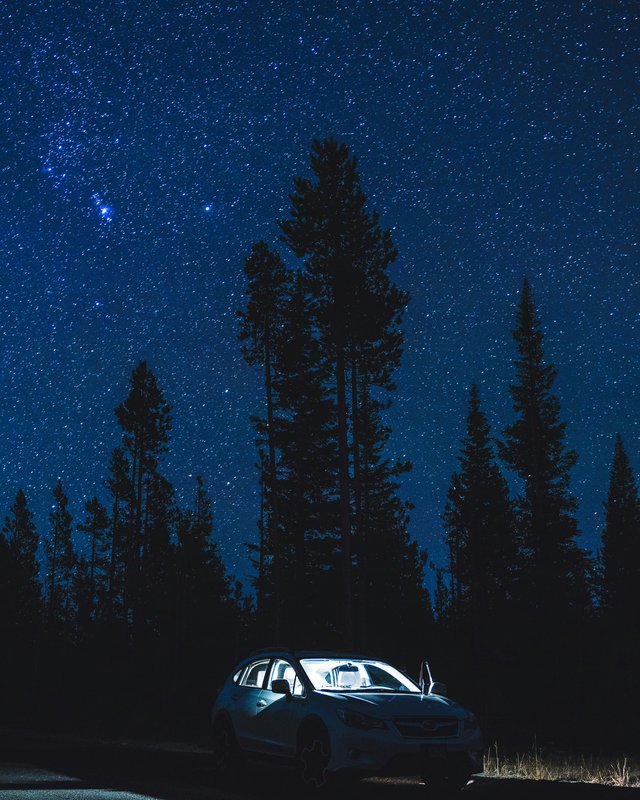

In [33]:
import os
from PIL import Image
from IPython.display import display

# Folder to search
image_folder = "C:\\Users\\vaibhava\\usecasedev\\image_search_case_study\\data\\images"

def find_image_by_name(filename, folder=image_folder):
    for root, dirs, files in os.walk(folder):
        if filename in files:  # exact match
            return os.path.join(root, filename)
    return None  # not found

# Example usage
image_name = "19017.jpg"
image_path = find_image_by_name(image_name)

if image_path:
    print(f"Image found: {image_path}")
    # Open and display image
    img = Image.open(image_path)
    display(img)
else:
    print("Image not found")
